In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import gc
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat, loadmat
import twixtools
from twixtools.recon_helpers import remove_oversampling
import matplotlib.pyplot as plt

## My files
from plot_helpers import *
import raw_data_utils
from resp_signal_utils import *

In [2]:
data_path = Path('/home/lilianae/data/NaF_MtSinai/')
output_path = parent_folder/Path('data/processed/')
print(f'output path = {output_path}')

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
data_file_pt4 = '/data/lilianae/NaF_Patient4/anon_meas_MID00062_FID67913_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS_Qfatsat.dat'

output path = /home/lilianae/projects/naf_clean/data/processed


## 1. Example: read_twix for low-level acess

In [3]:
multi_twix = twixtools.read_twix(str(data_file_pt4))

Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.25GB/s]


In [4]:
chronological_data = []

for i, mdb in enumerate(multi_twix[-1]['mdb']):
    ## Use same logic as twix_category['image'] to get mdh values for k-space
    if (not mdb.is_flag_set('SYNCDATA') and
        not mdb.is_flag_set('ACQEND') and
        not mdb.is_flag_set('RTFEEDBACK') and
        not mdb.is_flag_set('HPFEEDBACK') and
        not mdb.is_flag_set('REFPHASESTABSCAN') and
        not mdb.is_flag_set('PHASESTABSCAN') and
        not mdb.is_flag_set('PHASCOR') and
        not mdb.is_flag_set('NOISEADJSCAN') and
        not mdb.is_flag_set('noname60') and
        (not mdb.is_flag_set('PATREFSCAN') or mdb.is_flag_set('PATREFANDIMASCAN'))):
    
        if not np.isnan(mdb.mdh.TimeStamp):
            ## Extract k-space data for this readout
            mdb_data = mdb.data  # Shape: (channels, samples)

            ## Apply oversampling removal to ensure consistent array sizes
            if mdb_data.shape[-1] == 512:  ## if we have 512 points, this is an image line. If there are 704 points, it is a noise scan. Discovered from manual inspection

                mdb_data, _ = remove_oversampling(mdb_data, x_was_in_timedomain=True)
                mdb_data = mdb_data[:, :256]    ## Only take first 256 samples, same as logic Michael used in former data processing code
                
                
                chronological_data.append({
                    'timestamp': mdb.mdh.TimeStamp,
                    'partition': mdb.mdh.Counter.Par,
                    'line': mdb.mdh.Counter.Lin,
                    'kspace_data': mdb_data,  # Shape: (channels, 256)
                    'ice_param': mdb.mdh.IceProgramPara,
                    'acquisition_index': i  # Original position in MDB list
                })

In [5]:
sorted_chronological_data = sorted(chronological_data, key=lambda x: x['timestamp'])

In [6]:
print("\nFirst 10 data points (chronological order):")
for i in range(min(10, len(sorted_chronological_data))):
    data_point = sorted_chronological_data[i]
    print(f"  Time {i}: Par={data_point['partition']}, Lin={data_point['line']}, "
        f"Timestamp={data_point['timestamp']}, IceProgramPara={data_point['ice_param']}")


First 10 data points (chronological order):
  Time 0: Par=0, Lin=0, Timestamp=21604187, IceProgramPara=[45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 1: Par=2, Lin=0, Timestamp=21604190, IceProgramPara=[45  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 2: Par=3, Lin=0, Timestamp=21604192, IceProgramPara=[45  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 3: Par=4, Lin=0, Timestamp=21604194, IceProgramPara=[45  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 4: Par=7, Lin=0, Timestamp=21604197, IceProgramPara=[45  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 5: Par=8, Lin=0, Timestamp=21604199, IceProgramPara=[45  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 6: Par=9, Lin=0, Timestamp=21604202, IceProgramPara=[45  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  Time 7: Par=10, Lin=0,

In [11]:
print("\n Showing mdb values for measurements [0, 10, 100, 1000, 10000]:")
for i in [0, 10, 100, 1000, 10000]:
    data_point = sorted_chronological_data[i]
    print(f"\n  Time {i}: Par={data_point['partition']}, Lin={data_point['line']}, "
        f"Timestamp={data_point['timestamp']}, IceProgramPara={data_point['ice_param']}")


 Showing mdb values for measurements [0, 10, 100, 1000, 10000]:

  Time 0: Par=0, Lin=0, Timestamp=21604187, IceProgramPara=[45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

  Time 10: Par=15, Lin=0, Timestamp=21604211, IceProgramPara=[45  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

  Time 100: Par=29, Lin=1, Timestamp=21604442, IceProgramPara=[ 45   0 637   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]

  Time 1000: Par=0, Lin=16, Timestamp=21606776, IceProgramPara=[ 45   6 471   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]

  Time 10000: Par=0, Lin=170, Timestamp=21630073, IceProgramPara=[ 45  64 715   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [8]:
# Check the full pattern for line 0
line_0_partitions = []
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 0:
        line_0_partitions.append(chronological_data[i]['partition'])

print(f"Partition order for line 0: {line_0_partitions}")
print(f"Number of unique partitions: {len(set(line_0_partitions))}")

# Also check when line 1 starts
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 1:
        print(f"Line 1 starts at acquisition {i}, partition {chronological_data[i]['partition']}")
        break

Partition order for line 0: [0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19, 21, 22, 24, 25, 26, 28, 29, 31, 32, 33, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 53, 54, 55, 56, 1, 5, 12, 13, 18, 20, 23, 27, 30, 34, 35, 40, 44, 46, 51, 57, 6, 52]
Number of unique partitions: 58
Line 1 starts at acquisition 41, partition 2


## 2. Example: map_twix for high-level access

In [9]:
mapped = twixtools.map_twix(multi_twix)

Number of readout points = 256, Full number of partitions = 72

Non-singleton dimensions of k-space array: 
    data_0.non_singleton_dims = ['Eco', 'Par', 'Lin', 'Cha', 'Col']

K-space data dimensions after squeezing:
    ksp_data.shape = (58, 2002, 15, 256)

Final shape (transpose dimensions):
    ksp_data.shape = (15, 58, 2002, 256)
Average value, slices vs samples per gate = 1.0259317605232354e-05
Average value, readouts vs spokes per gate = 6.189437499415362e-06
Average value, slices vs center sample per gate = 5.0106042181141675e-05


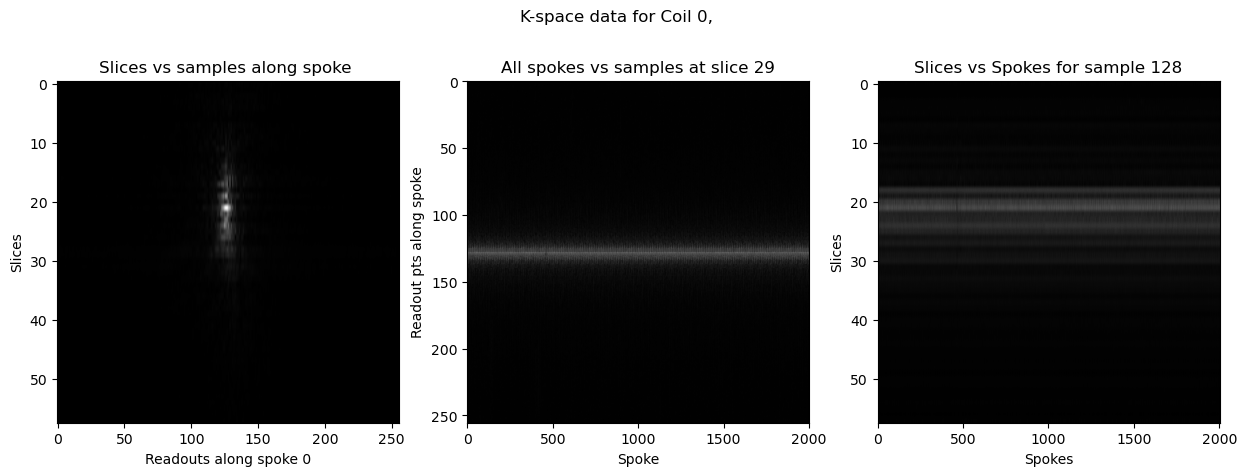

In [10]:
data_0 = mapped[0]['image']
data_0.flags['remove_os']=True                              ## Remove Oversampling
echo_num=0                                                  ## First echo is spoke data
num_points = int(mapped[0]['hdr']['Config']['NImageLins'])  ## Get # of points on one spoke
num_full_par = int(mapped[0]['hdr']['Config']['NImagePar'])  ## Get full # of partitions

print(f'Number of readout points = {num_points}, Full number of partitions = {num_full_par}')

## Get relevant dimensions
print(f"\nNon-singleton dimensions of k-space array: ")
print(f"    data_0.non_singleton_dims = {data_0.non_singleton_dims}")


ksp_data = data_0[...,echo_num,0,0,0,:,0,0,:,:,:num_points]
ksp_data = ksp_data.squeeze()
print(f"\nK-space data dimensions after squeezing:")
print(f"    ksp_data.shape = {ksp_data.shape}")

ksp_data = np.transpose(ksp_data,(2,0,1,3))
print(f"\nFinal shape (transpose dimensions):")
print(f'    ksp_data.shape = {ksp_data.shape}')  ## Shape = (15, 58, 2002, 256) -> (channels, partitions, lines, columns)

fig, axs = plot_ksp_data_multichannel(ksp_data=ksp_data, coil_idx=0)